# Calculate robusteness from pi control runs

In [44]:
# Some definitions

# directory of data
#fdir = '~/Google Drive/professional/research/FARALLON_INSTITUTE_PROJECTS/2020 NOAA MAPP/Climate_extremes_sharedfigsandcode/data/FOR SCATTER PLOT/'
fdir = '/Volumes/GoogleDrive/My Drive/Climate_extremes_sharedfigsandcode/data/Annual_TimeSeries/'

In [45]:
# Modules
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') #filter some warning messages
import seaborn as sns

In [46]:
#detrend function: detrend use polynomial fit
def detrend(x,y,degree):
    import statsmodels.formula.api as smf
    import numpy as np
    import pandas as pd
    

    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = pd.Series(y)   #y

    idx = np.isfinite(x) & np.isfinite(y)
    weights = np.polyfit(x[idx], y[idx], degree)
    model = np.poly1d(weights)
    results = smf.ols(formula='y ~ model(x)', data=df).fit()

    p_value=results.f_pvalue
    r2=results.rsquared_adj

    detrend_ts=np.zeros(shape=(len(y),))
    detrend_ts[:] = np.nan
    detrend_ts[idx]=y[idx]-results.fittedvalues

    #plt.figure(figsize=(10,4))
    #plt.plot(x,y)
    #plt.plot(x[idx], results.fittedvalues, 'r')
    #plt.figure(figsize=(10,4))
    #plt.plot(x, detrend_ts)
    #plt.show()

    return p_value, r2, detrend_ts

In [47]:
def num_coevents(y1, y2, ny,pct1, pct2, runs='picontrol',loc='cclme'):
    # 
    fin1 = fdir+'original ts/'+runs+'_'+loc+'_sst.nc'
    fin2 = fdir+'original ts/'+runs+'_sm.nc'
    modsst = xr.open_dataset(fin1)
    modsst.close()
    modsm2 = xr.open_dataset(fin2)
    modsm2.close()
    
    models = modsm2.model

    # selec periood
    modsst = modsm2.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1-1,y2-1))
    
    nev = list()
    
    for ix,i in enumerate(models):
        #print(ix,i)
        tmp1_0= modsst.sel(model=i).sm.values
        tmp2_0= modsm2.sel(model=i).sm.values
        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
    
        # calculate threshold
        mhw_thr = np.nanpercentile(tmp1,pct2)
        drg_thr = np.nanpercentile(tmp2,pct2)
    
        a1 = tmp1<=mhw_thr
        a2 = tmp2<=drg_thr
        
        tmp = np.full((len(modsst.year.values),1),1)
        tmp = tmp[a1*a2]
    
        nev.append(len(tmp)/ny*100)#/(y2-y1+1)) #freq.
        
    return nev  # sum(nev)

In [48]:
ny = 30
prc1 = 90
prc2 = 10
loc='cclme'

pinev=list()
for i in range(int(500/ny)):
    nev = num_coevents(i*ny+2, (i+1)*ny+1,ny, prc1, prc2,loc=loc)
    #print(i)
    #print(i*ny+2, (i+1)*ny+1)
    pinev.append(nev)
pinev 

[[3.3333333333333335,
  0.0,
  0.0,
  3.3333333333333335,
  0.0,
  3.3333333333333335,
  0.0,
  0.0,
  6.666666666666667,
  0.0,
  3.3333333333333335,
  3.3333333333333335,
  3.3333333333333335,
  0.0,
  6.666666666666667,
  3.3333333333333335,
  3.3333333333333335,
  0.0,
  0.0,
  3.3333333333333335,
  0.0,
  0.0],
 [6.666666666666667,
  0.0,
  0.0,
  0.0,
  3.3333333333333335,
  6.666666666666667,
  0.0,
  3.3333333333333335,
  3.3333333333333335,
  6.666666666666667,
  3.3333333333333335,
  3.3333333333333335,
  3.3333333333333335,
  0.0,
  3.3333333333333335,
  3.3333333333333335,
  3.3333333333333335,
  3.3333333333333335,
  0.0,
  3.3333333333333335,
  3.3333333333333335,
  3.3333333333333335],
 [6.666666666666667,
  0.0,
  0.0,
  0.0,
  3.3333333333333335,
  0.0,
  0.0,
  0.0,
  3.3333333333333335,
  3.3333333333333335,
  0.0,
  3.3333333333333335,
  3.3333333333333335,
  0.0,
  6.666666666666667,
  0.0,
  3.3333333333333335,
  6.666666666666667,
  0.0,
  0.0,
  3.33333333333333

In [49]:
#model by model

In [50]:
model_mean=np.mean(pinev,axis=0)
model_spread=np.std(pinev,axis=0)
IV=(np.sum((model_spread*model_spread))/22)**.5
IV,model_spread

(1.9829011815921629,
 array([2.19492787, 2.20479276, 2.04124145, 1.61374306, 2.03058216,
        2.31990182, 1.30104125, 1.65359457, 2.19492787, 2.04124145,
        2.31990182, 1.54504135, 1.61374306, 1.54504135, 1.86338998,
        2.11435241, 1.54504135, 2.31990182, 2.3570226 , 1.66666667,
        2.49130432, 2.03058216]))

In [51]:
#16 30-yr periods MMEs

In [52]:
mme_mean=np.mean(pinev,axis=1)
mme_spread=np.std(pinev,axis=1)
#internal variability mean and spread
mme_mean,np.mean(mme_spread)

(array([1.96969697, 2.87878788, 1.96969697, 2.42424242, 2.57575758,
        2.12121212, 2.27272727, 1.96969697, 2.12121212, 2.12121212,
        2.12121212, 2.42424242, 2.27272727, 2.27272727, 2.27272727,
        3.03030303]),
 2.147129438684142)

In [53]:
#MME mean and spread

In [54]:
mme_model_mean=np.mean(mme_mean)
mme_model_spread=np.std(mme_mean)
mme_model_mean,mme_model_spread

(2.301136363636364, 0.2993083452514983)

In [55]:
#cross model mean and spread

In [56]:
cross_model_mean=np.mean(model_mean)
cross_model_spread=np.std(model_mean)
cross_model_mean,cross_model_spread

(2.3011363636363638, 0.9177792678173015)

In [57]:
IV,cross_model_spread,mme_model_spread,np.std(pinev),np.std(pinev)-IV

(1.9829011815921629,
 0.9177792678173015,
 0.2993083452514983,
 2.184997913132838,
 0.20209673154067498)

In [58]:
## Calculate thresholds for PI Control runs

In [59]:
def get_thre(fdir, runs,loc, y1,y2,prc1,prc2):
    # open data: anomalies (without trend)

    modsst = xr.open_dataset(fdir+'original ts/'+runs+'_'+loc+'_sst.nc')
    modsst.close()
    modsm2 = xr.open_dataset(fdir+'original ts/'+runs+'_sm.nc')
    modsm2.close()

    # select period 
    modsst = modsm2.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1-1,y2-1))
    mhw_thr = list()
    drg_thr = list()
    models = list()

    # Calculate thresholds for each model
    for ix,i in enumerate(modsm2.model.values):
        tmp1_0= modsst.sel(model=i).sm.values
        tmp2_0= modsm2.sel(model=i).sm.values
        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
        
        mhw_thr.append(np.nanpercentile(tmp1,prc2))
        drg_thr.append(np.nanpercentile(tmp2,prc2))

        models.append(i)
    
    return mhw_thr, drg_thr, models

In [60]:
# calculate number of events for control, historical and future
# based on thresholds in each run

def freq_coevents(fdir, runs, loc, mhw_thr, drg_thr, models, y1, y2):
    #pi control
    fi1 = fdir+'original ts/'+runs+'_'+loc+'_sst.nc'
    fi2 = fdir+'original ts/'+runs+'_sm.nc'
    modsst = xr.open_dataset(fi1)
    modsst.close()
    modsm2 = xr.open_dataset(fi2)
    modsm2.close()

    # select period
    modsst = modsm2.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1-1,y2-1))

    nev = list()
    ts_sst=list()
    ts_sm=list()

    for ix,i in enumerate(models):
        #print(ix,i)
        tmp1_0= modsst.sel(model=i).sm.values
        tmp2_0= modsm2.sel(model=i).sm.values
        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
        
        ts_sst.append(tmp1)
        ts_sm.append(tmp2)
   
        a1 = tmp1<=mhw_thr[ix]
        a2 = tmp2<=drg_thr[ix]
        tmp = np.full((len(modsst.year.values),1),1)
        tmp = tmp[a1*a2]

        nev.append(len(tmp)/30*100)
    
    freq = np.array(nev)/(y2-y1+1)
    
    plt.figure(figsize=(10,4))
    plt.plot(nsample, np.asarray(ts_sst).T)
    plt.show()
    plt.figure(figsize=(10,4))
    plt.plot(nsample, np.asarray(ts_sm).T)
    plt.show()
    return nev,np.round(np.nanmean(nev),4), np.round(np.nanstd(nev),4) #mean no. of events
#freq, np.round(np.nanmean(freq),4), np.round(np.nanstd(freq),4) #mean frequency


In [61]:
def freq_difruns(fdir,loc, ny, prc1, prc2):
    
  
    
    # calculate threshold in historical 1
    y1 = 1901
    y2 = y1+ny-1
    mhw_thr, drg_thr, models = get_thre(fdir, 'historical',loc,y1,y2,prc1,prc2)

    # historical 1
    y1 = 1901
    y2 = y1+ny-1
    print('\nhistorical: '+str(y1)+'-'+str(y2))
    freq, mfrq, sfrq = freq_coevents(fdir,'historical',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)

       
       
    # calculate threshold in historical 2
    y2=2029
    y1=y2-ny+1
    mhw_thr, drg_thr, models = get_thre(fdir, 'histssp585',loc,y1,y2,prc1,prc2)

    # historical 2
    y2=2029
    y1=y2-ny+1
    print('\nhistorical 2: '+str(y1)+'-'+str(y2))
    freq1, mfrq, sfrq = freq_coevents(fdir,'histssp585',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)


    
       
    # calculate threshold in historical 2
    y2=2014
    y1=y2-ny+1
    mhw_thr, drg_thr, models = get_thre(fdir, 'historical',loc,y1,y2,prc1,prc2)

    # historical 2
    y2=2014
    y1=y2-ny+1
    print('\nhistorical 2: '+str(y1)+'-'+str(y2))
    freq, mfrq, sfrq = freq_coevents(fdir,'historical',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)


    # calculate threshold in future 1
    y2=2099+1
    y1=y2-ny+1
    mhw_thr, drg_thr, models = get_thre(fdir, 'ssp585',loc,y1,y2,prc1,prc2)

    # future 1
    y2=2099+1
    y1=y2-ny+1
    print('\nfuture: '+str(y1)+'-'+str(y2))
    freq2, mfrq, sfrq = freq_coevents(fdir,'ssp585',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)
    
    # calculate threshold in future 2
    y2=2069
    y1=y2-ny+1
    mhw_thr, drg_thr, models = get_thre(fdir, 'ssp585',loc,y1,y2,prc1,prc2)

    # future 2
    y2=2069
    y1=y2-ny+1
    print('\nfuture: '+str(y1)+'-'+str(y2))
    freq, mfrq, sfrq = freq_coevents(fdir,'ssp585',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)
 
    y2=2045
    y1=y2-ny+1
    mhw_thr, drg_thr, models = get_thre(fdir, 'ssp245',loc,y1,y2,prc1,prc2)

    # future 2
    y2=2045
    y1=y2-ny+1
    print('\nfuture: '+str(y1)+'-'+str(y2))
    freq1, mfrq, sfrq = freq_coevents(fdir,'ssp245',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)

    return freq1, freq2

In [62]:
# Frequency of events - detrended data, using individual threshols
## percentiles 90-10


Percentiles: 90/10

Probable # events in 30 years: 0.3

historical: 1901-1930


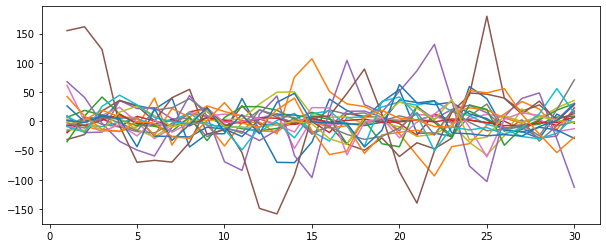

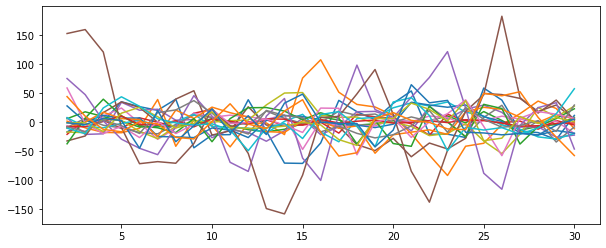

2.1212 1.8924

historical 2: 2000-2029


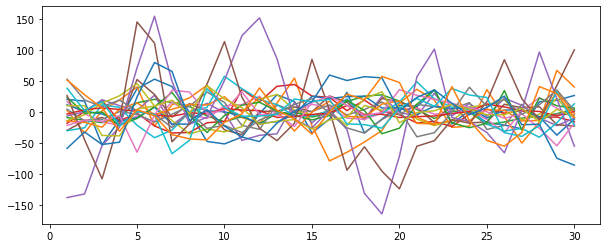

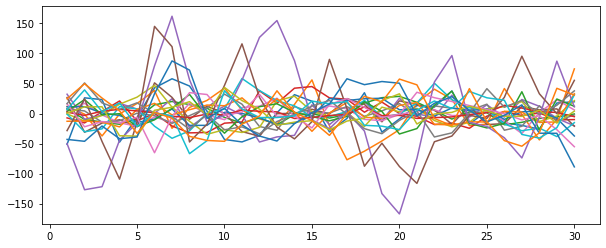

3.0303 1.9871

historical 2: 1985-2014


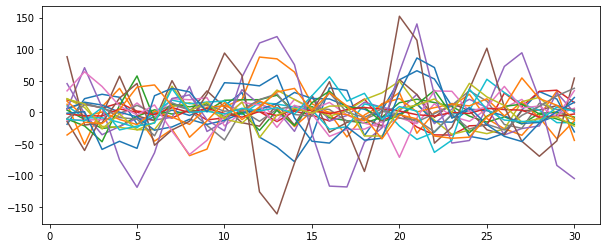

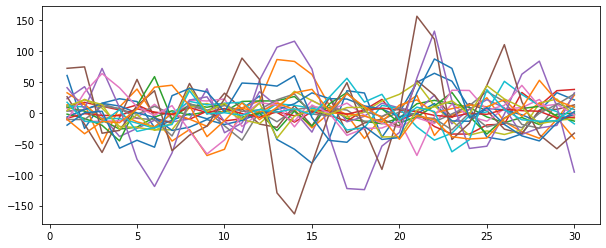

2.2727 2.1049

future: 2071-2100


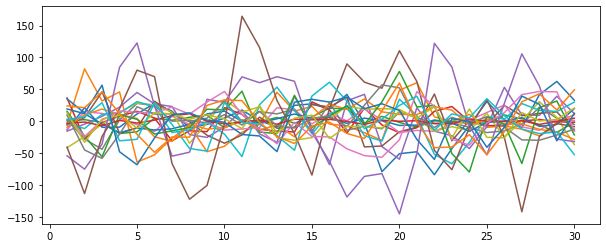

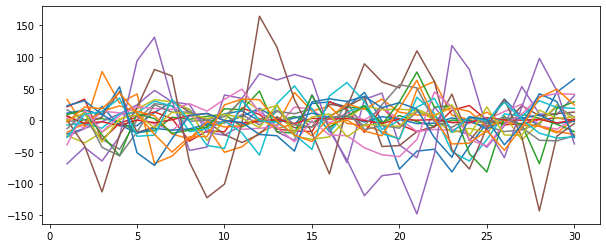

1.9697 1.9225

future: 2040-2069


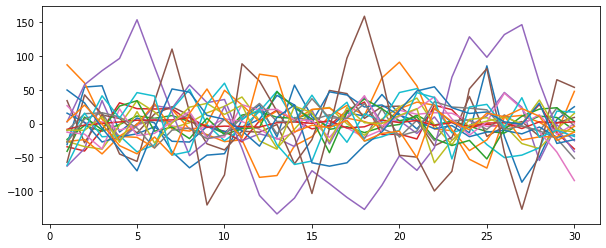

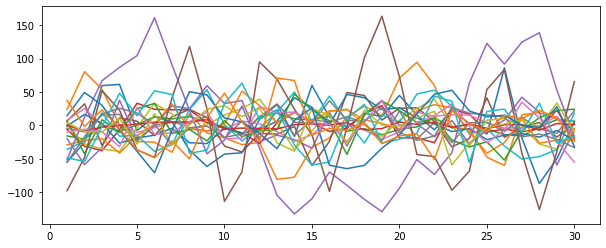

2.4242 2.0553

future: 2016-2045


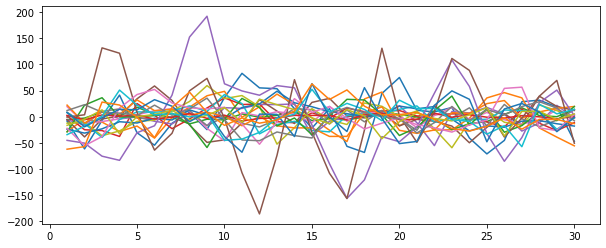

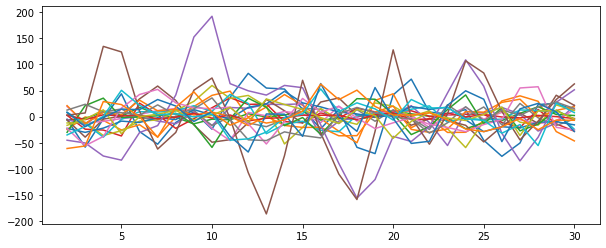

2.2727 1.8495


[3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 0.0,
 0.0,
 3.3333333333333335,
 0.0,
 3.3333333333333335,
 0.0,
 3.3333333333333335,
 0.0,
 3.3333333333333335,
 0.0,
 0.0,
 3.3333333333333335,
 0.0,
 6.666666666666667,
 3.3333333333333335,
 0.0,
 3.3333333333333335,
 3.3333333333333335,
 0.0]

In [63]:

print ('\nPercentiles: '+str(prc1)+'/'+str(prc2))
print('\nProbable # events in '+str(ny)+' years'+': '+str(ny*0.01))

hinev,funev=freq_difruns(fdir,loc,ny, prc1, prc2)
funev

In [64]:
loc,np.mean(hinev),np.mean(model_mean),np.mean(funev)

('cclme', 2.2727272727272734, 2.3011363636363638, 1.9696969696969702)

In [65]:
N=int(500/ny)
N

16

In [66]:
#hist - picontrol FAR

In [67]:
diff=list()
for k in range(len(pinev)):
    zip_obj=zip(hinev,pinev[k])
    for i , j in zip_obj:
            diff.append(i-j)
    #diff mean, model spread
diff_a=np.asarray(diff).reshape(N,22)
diff_mean=np.mean(diff_a,axis=1)
diff_spread=np.std(diff_mean)
diff_mean.mean(),diff_spread

(-0.028409090909090905, 0.29930834525149824)

In [68]:
hinev_a=np.asarray(hinev).sum()#.reshape(N,22).sum(axis=1)
pinev_a=np.asarray(pinev).reshape(N,22).sum(axis=1)
far=(hinev_a-pinev_a)/hinev_a
FAR=np.mean(far)
sd=np.std(far)
FAR,sd

(-0.012499999999999841, 0.13169567191065923)

In [69]:
import statsmodels.api as sm
import statsmodels as sm
import pandas
from patsy import dmatrices
cu,cl=sm.stats.proportion.proportion_confint(FAR, 1, alpha=0.05, method='normal') #'binom_test''normal'
cu,cl

(nan, nan)

In [70]:
#future - hist change

In [71]:
diff=np.mean(funev)-np.mean(hinev)
diff

-0.3030303030303032

In [72]:
#diff=np.mean(funev)-np.mean(hinev)
#diff=funev-hinev
diff=list()
zip_obj=zip(funev,hinev)
for i , j in zip_obj:
        diff.append(i-j)
diff
diff_mean=np.mean(diff)
diff_spread_mme=np.std(diff)
diff_mean,diff_spread_mme-IV,mme_model_spread

(-0.303030303030303, 0.2439076754834535, 0.2993083452514983)

In [73]:
#future - picontrol

In [74]:
#cross-model spread
diff=list()
for k in range(len(pinev)):
    zip_obj=zip(funev,pinev[k])
    for i , j in zip_obj:
            diff.append(i-j)
    #diff mean, model spread
diff_mean=np.mean(diff)
diff_spread=np.std(diff)-IV
diff_mean,diff_spread

(-0.3314393939393939, 0.8122960790899676)

In [75]:
#cross-mme spread
diff=list()
for k in range(len(pinev)):
    zip_obj=zip(funev,pinev[k])
    for i , j in zip_obj:
            diff.append(i-j)
    #diff mean, model spread
diff_a=np.asarray(diff).reshape(N,22)
diff_mean=np.mean(diff_a,axis=1)
diff_spread=np.std(diff_mean)
diff_mean.mean(),diff_spread

(-0.3314393939393939, 0.29930834525149824)

In [76]:
funev_a=np.asarray(funev).sum()#.reshape(N,22).sum(axis=1)
pinev_a=np.asarray(pinev).reshape(N,22).sum(axis=1)
far=(funev_a-pinev_a)/funev_a
FAR=np.mean(far)
sd=np.std(far)
FAR=np.mean(far)
cu,cl=sm.stats.proportion.proportion_confint(FAR, 1, alpha=0.05, method='normal') #'binom_test''normal'
FAR,cu,cl,sd

(-0.16826923076923067, nan, nan, 0.15195654451229912)